# Measurement of EIS and CV with processing of the data

This example shows how to use Python to remotely measure CV and EIS on a capacitor.
The two measurement data sets are read in and are further processed using Python. At the end, a PDF with the results is created.

In [2]:
import sys
import os

from thales_remote.connection import ThalesRemoteConnection
from thales_remote.script_wrapper import ThalesRemoteScriptWrapper,PotentiostatMode
from thales_remote.file_interface import ThalesFileInterface

from zahner_analysis.file_import.isc_import import IscImport
from zahner_analysis.file_import.ism_import import IsmImport

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.ticker import EngFormatter
import jinja2

# Connect Python to the already launched Thales-Software

The variable **remoteIP** contains the IP address of the computer on which the Thales software is running and to which the ZENNIUM is connected via USB.  
In this case both are running on the same computer, so the address is *"localhost"*. This variable is passed to the two constructors to establish a connection via the interface classes.

All commands in use are documented on the following web page in detail:   
https://doc.zahner.de/thales_remote


Then a second connection is established with the [ThalesFileInterface](https://doc.zahner.de/thales_remote/file_interface.html) class. This connection is used to transfer the measurement data via TCP/IP, this is especially necessary if Thales is not running on the same computer as Python.

The last step is performing a DC-offset calibration. This should be done after half an hour of warm-up.

In [2]:
if __name__ == "__main__":
    remoteIP = "localhost"

    zenniumConnection = ThalesRemoteConnection()
    zenniumConnection.connectToTerm(remoteIP, "ScriptRemote")
    
    zahnerZennium = ThalesRemoteScriptWrapper(zenniumConnection)
    zahnerZennium.forceThalesIntoRemoteScript()

    measDataInterface = ThalesFileInterface(remoteIP)
    measDataInterface.disableSaveReceivedFilesToDisk()
    measDataInterface.enableKeepReceivedFilesInObject()
    measDataInterface.enableAutomaticFileExchange(fileExtensions="*.ism*.isc")
    
    zahnerZennium.calibrateOffsets()
    

connection successfull


# Perform an CV measurement

In this example an electrolytic capacitor is analyzed, therefore the CV is measured between 0 V and 1 V. A slew rate of 0.25 $\frac{V}{s}$ is used.

This CV measurement is parameterized with the [setter methods](https://en.wikipedia.org/wiki/Mutator_method) in the following lines.  
The specified path is the path on the computer on which Thales is running.

After parameterization the parameters are checked and the CV measurement is started.

In [ ]:
    zahnerZennium.setCVStartPotential(0)
    zahnerZennium.setCVUpperReversingPotential(1)
    zahnerZennium.setCVLowerReversingPotential(0)
    zahnerZennium.setCVEndPotential(0)
    
    zahnerZennium.setCVStartHoldTime(2)
    zahnerZennium.setCVEndHoldTime(2)
    
    zahnerZennium.setCVCycles(1.5)
    zahnerZennium.setCVSamplesPerCycle(400)
    
    zahnerZennium.setCVMaximumCurrent(1e-3)
    zahnerZennium.setCVMinimumCurrent(-1e-3)
    
    zahnerZennium.setCVOhmicDrop(0)
    
    zahnerZennium.disableCVAutoRestartAtCurrentOverflow()
    zahnerZennium.disableCVAutoRestartAtCurrentUnderflow()
    zahnerZennium.disableCVAnalogFunctionGenerator()
    
    zahnerZennium.setCVNaming("individual")
    zahnerZennium.setCVOutputPath(r"C:\THALES\temp\cv")
    zahnerZennium.setCVOutputFileName("cv_measurement")
    
    scanRate = 0.25
    
    zahnerZennium.setCVScanRate(scanRate)
    
    zahnerZennium.checkCVSetup()
    zahnerZennium.measureCV()

# Processing of the CV Measurement Data

First, the received measurement file is read in from the **ThalesFileInterface** object. 
 
Then the capacitance of the capacitor is determined using the following formula:  
$Capacity = \dfrac{I}{\frac{dV}{dt}}$

The measurement data are then plotted with [Matplotlib](https://matplotlib.org/) and the [plot is saved](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html) as a PDF vector graphic.

2.395 mF Capacitor


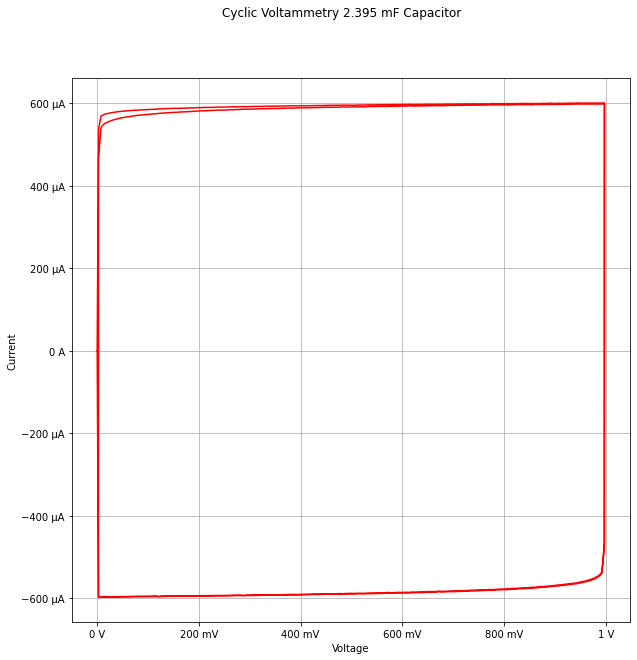

In [4]:
    CVmeasurementData = IscImport(measDataInterface.getLatestReceivedFile().binaryData)
    maximumCurrent = max(CVmeasurementData.getCurrentArray())
    minimumCurrent = min(CVmeasurementData.getCurrentArray())
    
    capacitance = ((maximumCurrent-minimumCurrent)/2)/scanRate
    
    capacitanceFormatter = EngFormatter(places=3, unit="F")
    print(f"{capacitanceFormatter.format_data(capacitance)} Capacitor")
    
    figCV, (axis) = plt.subplots(1, 1)
    figCV.suptitle(f"Cyclic Voltammetry {capacitanceFormatter.format_data(capacitance)} Capacitor")
    
    axis.plot(CVmeasurementData.getVoltageArray(), CVmeasurementData.getCurrentArray(), color = "red")
    
    axis.grid(which="both")
    axis.xaxis.set_major_formatter(EngFormatter(unit="V"))
    axis.yaxis.set_major_formatter(EngFormatter(unit="A"))
    axis.set_xlabel(r"Voltage")
    axis.set_ylabel(r"Current")
    
    figCV.set_size_inches(10, 10)
    plt.show()
    figCV.savefig("CV.pdf")

# Perform an EIS measurement

The parameters for the impedance measurement are set with the appropriate setter methods, so that the measurement is performed at 0 V with 10 mV amplitude.

In [ ]:
    zahnerZennium.setEISNaming("individual")
    zahnerZennium.setEISOutputPath(r"C:\THALES\temp")
    zahnerZennium.setEISOutputFileName("eis_measurement")
    
    zahnerZennium.setPotentiostatMode(PotentiostatMode.POTMODE_POTENTIOSTATIC)
    zahnerZennium.setAmplitude(10e-3)
    zahnerZennium.setPotential(0)
    zahnerZennium.setLowerFrequencyLimit(10)
    zahnerZennium.setStartFrequency(10)
    zahnerZennium.setUpperFrequencyLimit(500000)
    zahnerZennium.setLowerNumberOfPeriods(3)
    zahnerZennium.setLowerStepsPerDecade(5)
    zahnerZennium.setUpperNumberOfPeriods(20)
    zahnerZennium.setUpperStepsPerDecade(5)
    zahnerZennium.setScanDirection("startToMin")
    zahnerZennium.setScanStrategy("single")
    
    zahnerZennium.enablePotentiostat()
    zahnerZennium.measureEIS()
    zahnerZennium.disablePotentiostat()
    
    zahnerZennium.setAmplitude(0)

# Processing of the EIS Measurement Data

After the measurement, the measurement data are displayed with Matplotlib in a Bode diagram.

The measurement data for CV (isc-files) and EIS (ism-files) are read in with the [IscImport](https://doc.zahner.de/zahner_analysis/file_import/index.html#zahner_analysis.file_import.isc_import.IscImport) and [IsmImport](https://doc.zahner.de/zahner_analysis/file_import/index.html#zahner_analysis.file_import.ism_import.IsmImport) classes in Python.  
The binary file content of the file, as in the example presented here, or the path of the file can be used as parameter.

The two classes are documented under the following link:  
https://doc.zahner.de/zahner_analysis/file_import

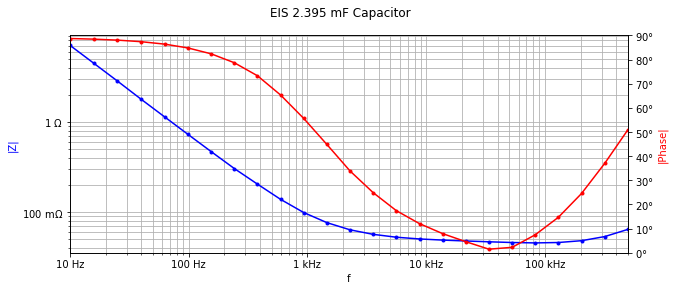

In [6]:
    EISmeasurementData = IsmImport(measDataInterface.getLatestReceivedFile().binaryData)
    
    zenniumConnection.disconnectFromTerm()
    measDataInterface.close()
    
    impedanceFrequencies = EISmeasurementData.getFrequencyArray()
    impedanceAbsolute = EISmeasurementData.getImpedanceArray()
    impedancePhase = EISmeasurementData.getPhaseArray()
    figBode, (impedanceAxis) = plt.subplots(1, 1)
    figBode.suptitle(f"EIS {capacitanceFormatter.format_data(capacitance)} Capacitor")
    
    phaseAxis = impedanceAxis.twinx()
    
    impedanceAxis.loglog(impedanceFrequencies, impedanceAbsolute, marker="o", markersize=3, color = "blue")
    impedanceAxis.xaxis.set_major_formatter(EngFormatter(unit="Hz"))
    impedanceAxis.yaxis.set_major_formatter(EngFormatter(unit="$\Omega$"))
    impedanceAxis.set_xlabel(r"f")
    impedanceAxis.set_ylabel(r"|Z|")
    impedanceAxis.yaxis.label.set_color("blue")
    impedanceAxis.grid(which="both")
    impedanceAxis.set_xlim([min(impedanceFrequencies), max(impedanceFrequencies)])
    
    phaseAxis.semilogx(impedanceFrequencies, np.abs(impedancePhase * (360 / (2 * np.pi))), marker="o", markersize=3, color = "red")
    phaseAxis.yaxis.set_major_formatter(EngFormatter(unit="$°$", sep=""))
    phaseAxis.xaxis.set_major_formatter(EngFormatter(unit="Hz"))
    phaseAxis.set_xlabel(r"f")
    phaseAxis.set_ylabel(r"|Phase|")
    phaseAxis.yaxis.label.set_color("red")
    phaseAxis.set_ylim([0, 90])
    figBode.set_size_inches(10, 4)
    plt.show()
    figBode.savefig("EIS.pdf")

To allow for drawing a table with the impedance measuring points in the PDF, the measurement data are exported as csv.

Here, small adaptions are necessary for LaTeX in terms of correct display of the micro sign ($\mu$) and the minus sign.  
Everything is written with [utf-8 encoding](https://en.wikipedia.org/wiki/UTF-8) in the files, that all characters can be displayed without problems.

In [7]:
    mpl.rcParams["axes.unicode_minus"] = False
    prefixFormatter = EngFormatter(places=3, sep = "")
    defaultMu = prefixFormatter.ENG_PREFIXES[-6]
    prefixFormatter.ENG_PREFIXES[-6] = "\\textmu" #LaTeX notation for micro
    
    with open("EIS.csv","wb") as file:
        file.write(bytearray("Frequency;Impedance;Phase" + os.linesep, "utf-8"))
        
        for freq, imp, phase in zip(impedanceFrequencies, impedanceAbsolute, impedancePhase):
            file.write(bytearray(f"{prefixFormatter.format_data(freq)};{prefixFormatter.format_data(imp)};{prefixFormatter.format_data(phase * (360 / (2 * np.pi)))}" + os.linesep, "utf-8"))
    

# Generate Report

First, the Python command line input function **input()** is used to request a name for the test object from the user.

In [8]:
    objectName = input("Input Test Object Identifier:")

To create a PDF, [LaTeX](https://www.latex-project.org/)/[MiKTeX](https://miktex.org/) is used. For this purpose, a tex-file is created as template which has placeholders for the [Jinja2](https://palletsprojects.com/p/jinja/) template engine. These placeholders are filled in with Python.

The placeholder for capacity is, for example: <code>\PYVAR{capacitance}</code>.

In the following, the Jinja2 enviroment is [initialized](http://eosrei.net/articles/2015/11/latex-templates-python-and-jinja2-generate-pdfs) and the template file is loaded.

In [9]:
    latex_jinja_env = jinja2.Environment(
        variable_start_string = '\PYVAR{',
        variable_end_string = '}',
        trim_blocks = True,
        autoescape = False,
        loader = jinja2.FileSystemLoader(os.path.abspath('.'))
    )
        
    template = latex_jinja_env.get_template(r"report.tex")

The render method now fills the placeholders. The assignments in the parameter list are used to pass the data from Python to the placeholders.

The table with the impedance measurement data is displayed by LaTeX, while the data are stored in the created csv-file. Only the filename of the csv-file is passed on.

The filled tex file is then written to the hard disk and [pdflatex.exe](https://docs.miktex.org/manual/miktex-pdftex.html) is called with appropriate parameters to create the PDF file.  
With *-jobname* the name of the PDF file is passed, which will be created. The **objectName** is inserted here.

At the end the generated pdf will be opened.

In [10]:
    currentFormatter = EngFormatter(unit="A")
    currentFormatter.ENG_PREFIXES[-6] = "\\mu " #LaTeX notation for micro
    
    fileString = template.render(
        objectname = objectName,
        capacitance = capacitanceFormatter.format_data(capacitance),
        cv_filename = "CV.pdf",
        eis_filename = "EIS.pdf",
        eis_csv_filename = "EIS.csv",
        cv_maximum_current = currentFormatter.format_data(maximumCurrent),
        cv_minimum_current = currentFormatter.format_data(minimumCurrent),
        cv_scanrate = scanRate
        )
    
    fileString = bytearray(fileString, "utf-8")
    f = open("report_filled.tex", "wb")
    f.write(fileString)
    f.close()
    
    # Only needed for Jupyter, that the kernel does not have to be restarted all the time.
    currentFormatter.ENG_PREFIXES[-6] = defaultMu
    
    command = f"pdflatex.exe report_filled.tex -jobname=\"{objectName}\""
    os.system(command)
    os.popen(f"{objectName}.pdf")
    print("finish")

finish
